In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
import os
import re
from transformers import AutoModel, AutoTokenizer

In [5]:
# model_name = 'DeepPavlov/rubert-base-cased-sentence'
model_name = 'DeepPavlov/bert-base-multilingual-cased-sentence'
# model_name = 'DeepPavlov/distilrubert-small-cased-conversational'
# model_name = 'DeepPavlov/distilrubert-tiny-cased-conversational'
model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [6]:
def get_first_header(note):
    if '## ' in note:
        first_header_prefix = '## '
        if '### ' in note:
            first_header_prefix = '### '

        first_header = note.split(first_header_prefix)[1].split('\n')[0]
    else:
        first_header = ''

    return first_header

def clean(note):
    # remove zero-links
    note = re.sub(r'\[.*\]', '', note)

    # remove tags and headers
    note = re.sub(r'\#.*\n', '', note)

    # remove \n
    note = re.sub('\n', ' ', note)

    # remove lines
    note = re.sub('---', ' ', note)

    # remove **
    note = re.sub('\*', '', note)
    
    return note

def num_letters(note):
    return len(re.sub(r'[^а-яА-Яa-zA-Z]', '', note))

In [7]:
length_thr = 100
device = torch.device(0)
# device = 'cpu'
encode_kwargs = {'truncation': True, 'padding': 'max_length', 'pad_to_multiple_of': 1, 'max_length':512}

In [8]:
db_path = '/home/booydar/Documents/Sync/obsidian-db/'


def parse_folder(path):
    # print(f'Parsing {path}')

    path, folders, files = next(os.walk(path))

    db_df = pd.DataFrame()
    if len(folders) > 0:
        for f in folders:
            folder_path = os.path.join(path, f)
            f_res_df = parse_folder(folder_path)
            db_df = pd.concat([db_df, f_res_df])

    for fn in files:
        if '.md' not in fn:
            continue

        filepath = os.path.join(path, fn)
        with open(filepath, 'r') as f:
            note = f.read()

        if num_letters(note) < length_thr:
            continue

        header = get_first_header(note)
        if not header: 
            header = fn[:-3]

        cleaned_note = clean(note)
        
        tokenized_header = tokenizer.encode(header, **encode_kwargs)
        tokenized_note = tokenizer.encode(cleaned_note, **encode_kwargs)

        note_dict = {'name': fn, 'path':filepath, 'header': header, 'note': cleaned_note, 'tokenized_header':[tokenized_header], 'tokenized_note':[tokenized_note], 'raw_note':[note]}

        db_df = pd.concat([db_df, pd.DataFrame(note_dict)])
    
    return db_df

def process_by_batch(model, tensor, batch_size = 2):
    n_chunks = tensor.shape[0] // batch_size
    chunked = torch.chunk(tensor, n_chunks)

    outputs = []
    for batch in chunked:
        out = model(batch.to(device)).last_hidden_state
        outputs.append(out.cpu().detach())
    return torch.cat(outputs)

In [9]:
db_df = parse_folder(db_path)

### Add PDF reader

In [16]:
pdf_path = "/home/booydar/Documents/Sync/obsidian-db/papers_labpc/2DZP8PT7/Zhang et al. - 2019 - ERNIE Enhanced Language Representation with Infor.pdf"
from PyPDF2 import PdfReader

reader = PdfReader(pdf_path)
text = ""
for page in reader.pages:
    text += page.extract_text() + "\n"


In [19]:
# print(text[:2500])

In [10]:
batch_size = 2
num_notes = db_df.shape[0]

model.to(device)
tokenized_headers = torch.Tensor(np.vstack(db_df.tokenized_header.values)).long()#.to(device)
tokenized_notes = torch.Tensor(np.vstack(db_df.tokenized_note.values)).long()#.to(device)

vectorized_headers = process_by_batch(model, tokenized_headers, batch_size)
vectorized_notes = process_by_batch(model, tokenized_notes, batch_size)

### average of sequence outputs as ambedding
header_embeddings = vectorized_headers.mean(dim=-2)
note_embeddings = vectorized_notes.mean(dim=-2)

### KMeans

In [11]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

In [22]:
metric = 'cosine'
min_n_clust, max_n_clust = 2, num_notes
header_silhouettes, note_silhouettes = [], []
for n_clust in range(min_n_clust, max_n_clust):
    cluster = KMeans(n_clusters=n_clust)#, affinity=metric)
    header_clusters = cluster.fit_predict(header_embeddings)
    note_clusters = cluster.fit_predict(note_embeddings)

    header_silhouettes.append(silhouette_score(header_embeddings, header_clusters))
    note_silhouettes.append(silhouette_score(note_embeddings, note_clusters))

/home/booydar/anaconda3/envs/cudaenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:996: ConvergenceWarning: Number of distinct clusters (51) found smaller than n_clusters (52). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


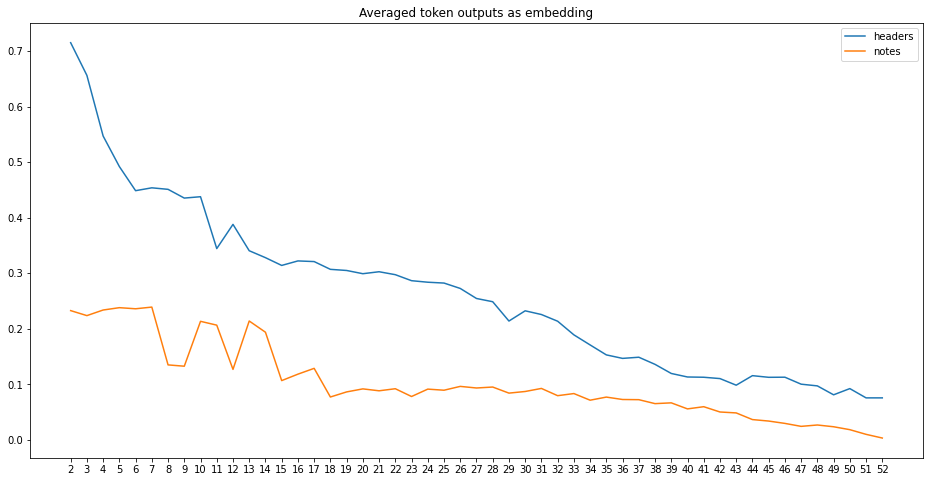

In [10]:
plt.figure(figsize=(16,8))
plt.title('Averaged token outputs as embedding')
clusters = list(range(min_n_clust, max_n_clust))
plt.plot(clusters, header_silhouettes)
plt.plot(clusters, note_silhouettes)

plt.legend(['headers', 'notes'])
plt.xticks(clusters)
plt.show()

### add cluster labels to notes

In [121]:
def add_tags(row):
    note, note_cluster, header_cluster = row['raw_note'], row['note_cluster'], row['header_cluster']
    if '---' not in note[-8:]:
        note += '\n\n---'
    cleaned_note = re.sub(r'\n\[\[NN.*]]\n---', '', note)

    tag_pattern = f'\n\n[[NN #{note_cluster}]] [[NN ##{header_cluster}]]\n\n---'
    filled_note = cleaned_note + tag_pattern    
    return filled_note

In [122]:
n_clust = 7
# cluster = KMeans(n_clusters=n_clust)
cluster = AgglomerativeClustering(n_clusters=n_clust)
header_clusters = cluster.fit_predict(header_embeddings)
headers = db_df.header.values

In [123]:
n_clust = 7
notes = db_df.note.values
# cluster = KMeans(n_clusters=n_clust)
cluster = AgglomerativeClustering(n_clusters=n_clust)
note_clusters = cluster.fit_predict(note_embeddings)

In [124]:
db_df['note_cluster'] = note_clusters
db_df['header_cluster'] = header_clusters

db_df['filled_note'] = db_df.apply(add_tags, axis=1)

In [125]:
# print(db_df.filled_note.iloc[0])

### Agglomerative

In [12]:
metric = 'euclidean'
min_n_clust, max_n_clust = 2, num_notes
header_silhouettes, note_silhouettes = [], []
for n_clust in range(min_n_clust, max_n_clust):
    cluster = AgglomerativeClustering(n_clusters = n_clust, affinity=metric)
    header_clusters = cluster.fit_predict(header_embeddings)
    note_clusters = cluster.fit_predict(note_embeddings)

    header_silhouettes.append(silhouette_score(header_embeddings, header_clusters))
    note_silhouettes.append(silhouette_score(note_embeddings, note_clusters))

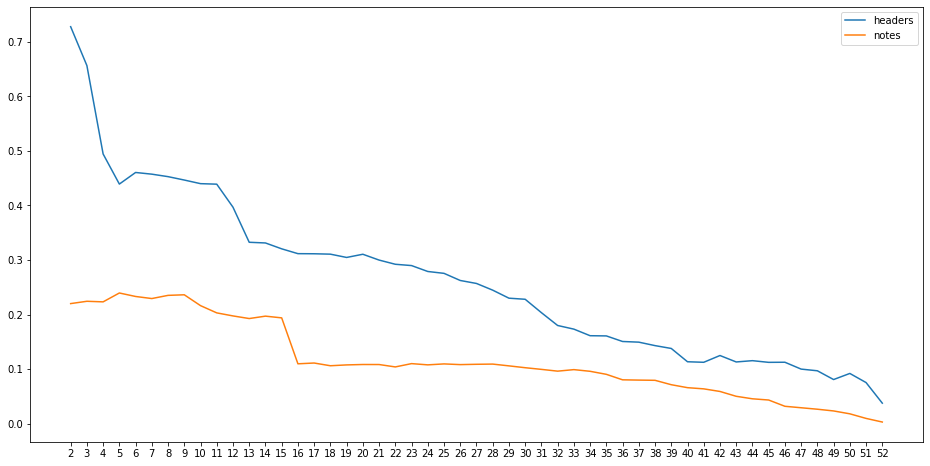

In [13]:
# average of sequence output as embedding
plt.figure(figsize=(16,8))

clusters = list(range(min_n_clust, max_n_clust))
plt.plot(clusters, header_silhouettes)
plt.plot(clusters, note_silhouettes)
plt.legend(['headers', 'notes'])
plt.xticks(clusters)
plt.show()

## recommendation


In [25]:
n_clust = 3
notes = db_df.note.values
cluster = KMeans(n_clusters=n_clust)
cluster = cluster.fit(note_embeddings)
note_clusters = cluster.predict(note_embeddings)

#### Find nearest cluster

In [41]:
text = '00:36    еду в такси с дня рождения Дениса. странное ощущение  (Айдар с утра: чел ты вина напился просто)'
tokenized_text = torch.Tensor([tokenizer.encode(text, **encode_kwargs)]).long().to(device)
vectorized_text = process_by_batch(model, tokenized_text, batch_size=1)
text_embedding = vectorized_text[:, 0, :].detach().numpy()
cn = cluster.predict(text_embedding.astype(float))[0]
recommended  = notes[note_clusters == cn]
# recommended   


#### get nearest samples

In [129]:
from sklearn.metrics import pairwise_distances_argmin, pairwise_distances

In [130]:
text = 'how does block-recurrence work? mb we can use it when recurrence  does forward '
tokenized_text = torch.Tensor([tokenizer.encode(text, **encode_kwargs)]).long().to(device)
vectorized_text = process_by_batch(model, tokenized_text, batch_size=1)
text_embedding = vectorized_text[:, 0, :].detach().numpy()

nearest_note_ind = pairwise_distances_argmin(text_embedding, note_embeddings, metric='cosine')
nearest_note = notes[nearest_note_ind]
nearest_note

array([' criteria 1) mft+ sized sensor? 2) has zoom or 16mp+ 3) fits in pocket or a small bag 4) attractive image 5) has raw 6) somewhat fast   - rx100m4+ Has really average photo quality but outstanding video  - a6300 Nice pics and vids but ugly (???) kit lens '],
      dtype=object)

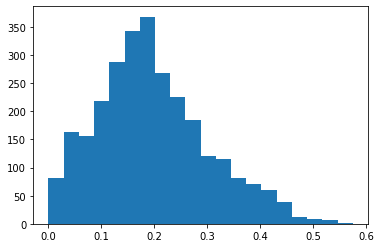

In [137]:
distances = pairwise_distances(note_embeddings, note_embeddings, metric='cosine')
plt.hist(distances.flatten(), bins=20)
plt.show()

In [139]:
thr = 0.1
(distances < thr).sum(), (distances < thr).mean()

(495, 0.1762192951228195)

In [107]:
distances = pairwise_distances(text_embedding, note_embeddings, metric='cosine')
nearest_notes = notes[np.argsort(distances)[:, :5]]
nearest_notes

array([['   - a faster way of post-processing images-  \t- create custom LUTs (do they fit all scenarios??) \t- maybe some ai \t- something for auto-hdr, exposure correction for Nikon  \t\t(or some substitute?)  - posting \t- post to (https://500px.com/booydar) regularly \t- instagram or some substitute  - portraits  \t- some basic info, like a course \t- insights from classic/recent photographers \t- insights from drawings: \t\t- what techniques could be replicated in photos??   - AI \t- merge video frames via averaging over sliding window \t- auto-cg, trained on lightroom presets  - gear \t',
        ' вы задумывались, почему все начинают бухать и торчебосить примерно в одном возрасте? это страх. 17-летний страх того, что острота ощущений детства уходит, притупляя вкус к жизни. кризис 22-25 лет состоит в переживании осознания никчемности остатка того, что тебе отведено ощутить. ничто не имеет "смысла", говорить об общем смысле может только фанатик. какой вот "смысл" заново переживать

### headers

In [108]:
n_clust = 6
# cluster = KMeans(n_clusters=n_clust)
cluster = AgglomerativeClustering(n_clusters=n_clust)
header_clusters = cluster.fit_predict(header_embeddings)
headers = db_df.header.values

In [109]:
for c in np.unique(header_clusters):
    group = headers[header_clusters == c]
    print(f'Cluster {c}\n{group}\n\n')

Cluster 0
['результаты' 'что такое вкус?' 'что такое искусство'
 'T5+ sparse attn + scaling '
 'Consider a group that emerges as a subgraph by a relation'
 'A vision of RMT as more than just one model' 'linux commands'
 'тотальное одиночество'
 'Use memorization/memory improvement techniques to teach memory'
 'Current state:' 'Do transformers need long contexts to solve long tasks'
 'Improve structure']


Cluster 1
['Tools for improving image-taking' 'Limitations of loss on each segment'
 'Auxillary losses to boost RMT'
 'Link prediction motivated by some objective' 'МБ - иррациональность'
 'P-Tuning v1' 'что-то потерялось']


Cluster 2
['Roadmap of ideas for taking images' 'Ideas for improving RMT on SCROLLS'
 'Лекция МБ по истории ИИ' 'Continuous learning of neural models'
 'Automatic tagging for notes using neural networks'
 'lists of conferences and deadlines']


Cluster 3
['books to read' 'Ideas' 'Ideas' 'Daily shooter' 'Meeting notes'
 'Memory pass variations' 'баскетбол' 'Meetin

#### notes

In [110]:
n_clust = 5
notes = db_df.note.values
# cluster = KMeans(n_clusters=n_clust)
cluster = AgglomerativeClustering(n_clusters=n_clust)
note_clusters = cluster.fit_predict(note_embeddings)

In [111]:
for c in np.unique(note_clusters):
    group = notes[note_clusters == c]
    print(f'Cluster {c}\n{group}\n\n')

Cluster 0
['   - a faster way of post-processing images-  \t- create custom LUTs (do they fit all scenarios??) \t- maybe some ai \t- something for auto-hdr, exposure correction for Nikon  \t\t(or some substitute?)  - posting \t- post to (https://500px.com/booydar) regularly \t- instagram or some substitute  - portraits  \t- some basic info, like a course \t- insights from classic/recent photographers \t- insights from drawings: \t\t- what techniques could be replicated in photos??   - AI \t- merge video frames via averaging over sliding window \t- auto-cg, trained on lightroom presets  - gear \t'
 '17:03      State Somewhere RMT improves baseline and its own predictions on previous segments (cnli), but on QA and summ second segment is worse than the first one (and than baseline). First segment also is worse than baseline   Ideas  - maybe finetune only memory weights?  \tsomehow separate memory weights from language weights and fine-tune only memory ones   - pre-train memory on task-agn